## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
##  camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

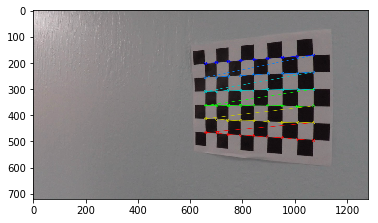

In [2]:
# calibration image example
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

calibration12 = cv2.imread('camera_cal/calibration12.jpg')
calibration12_gray = cv2.cvtColor(calibration12, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(calibration12_gray, (nx,ny),None)
# Draw and display the corners
calibration12 = cv2.drawChessboardCorners(calibration12, (nx,ny), corners, ret)
plt.imshow(calibration12)


In [3]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
calibration_images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in calibration_images:
    calibration_img = mpimg.imread(fname)
    calibration_gray = cv2.cvtColor(calibration_img, cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(calibration_gray, (nx,ny),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In [4]:
# Compute camera calibration mtx and dist
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, calibration_gray.shape[::-1], None, None)
print('Camera Matrix: %s' % mtx)
print('Distortion Coefficients: %s' % dist)

Camera Matrix: [[  1.15396093e+03   0.00000000e+00   6.69705375e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656224e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion Coefficients: [[ -2.41017944e-01  -5.30722012e-02  -1.15810358e-03  -1.28318396e-04
    2.67126913e-02]]


True

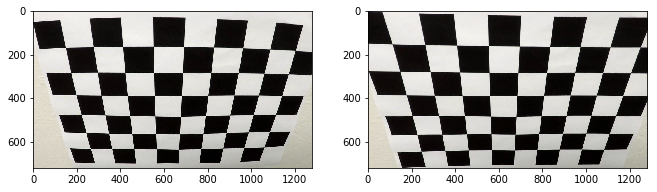

In [5]:
# Correct distortion on an image
calibration2 = mpimg.imread('camera_cal/calibration2.jpg')
calib2_udist = cv2.undistort(calibration2, mtx, dist, None, mtx)
# output
fig, ax = plt.subplots(1,2)
ax[0].imshow(calibration2)
ax[1].imshow(calib2_udist)
fig.set_size_inches(11,4)
# Saving to output folder
cv2.imwrite('output_images/calibration2_undistorted.jpg', calib2_udist)

True

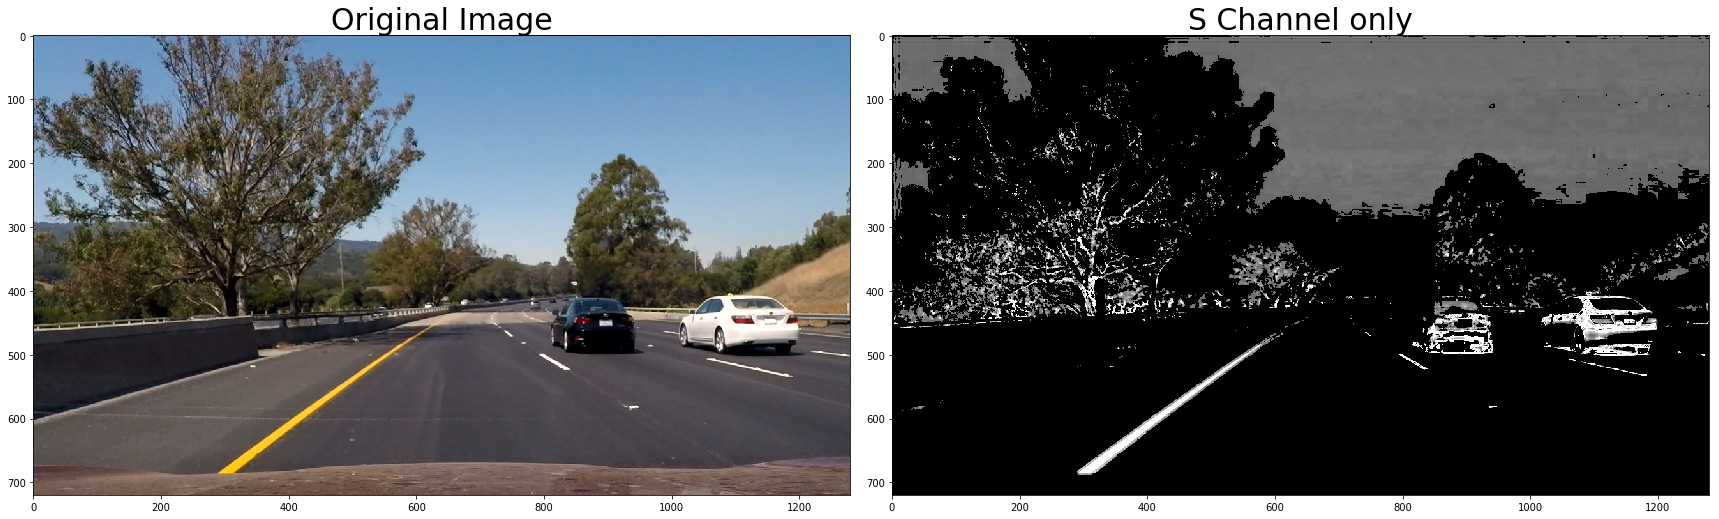

In [6]:
def threshold_image(img, thresh=(0, 255)):
    thresholded = img.copy()
    thresholded[thresholded <= thresh[0]] = 0
    thresholded[thresholded > thresh[1]] = 0
    return thresholded

# Thresholding channel s from a hls image
def get_S(img):
    thresh_s = (100, 255)
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) 
    return threshold_image(hls_img[:,:,2], thresh=thresh_s)

test6_img = mpimg.imread('test_images/test6.jpg')
s_img = get_S(test6_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test6_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(s_img, cmap='gray')
ax2.set_title('S Channel only', fontsize=30)
cv2.imwrite('output_images/test6_channel_S.jpg', s_img)

True

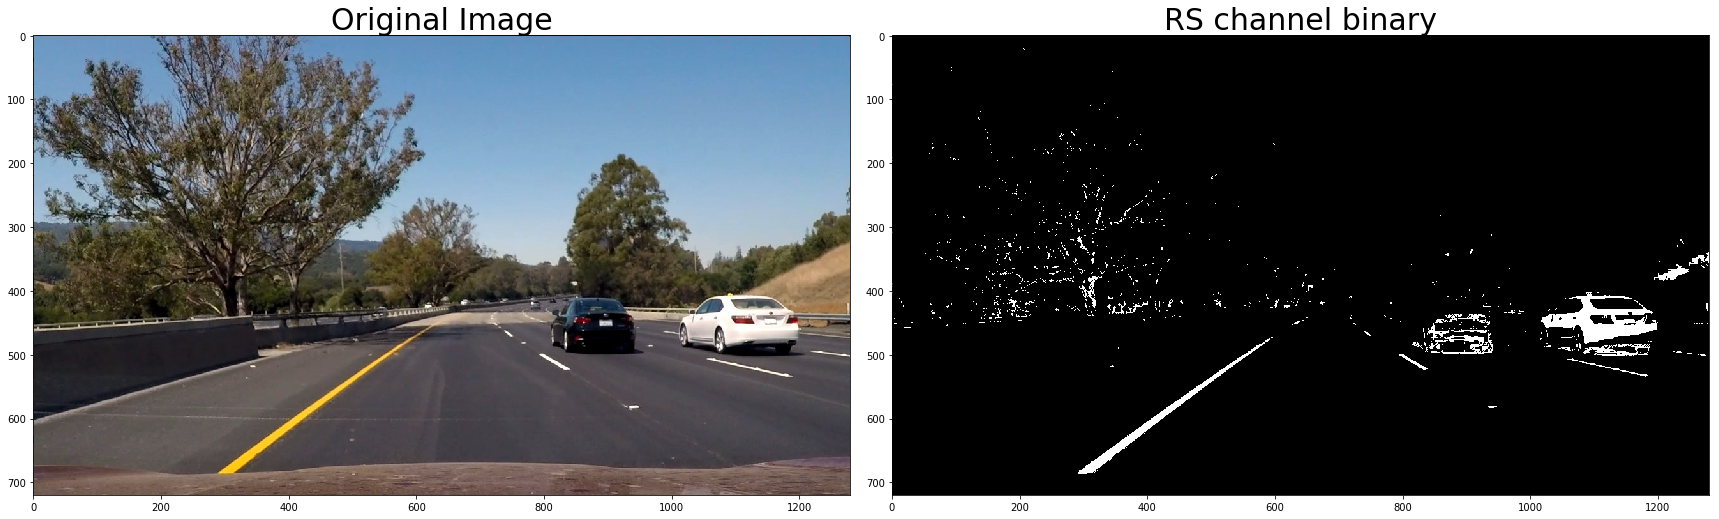

In [7]:
def get_binary(img):
    binary = np.zeros_like(img)
    binary[img > 0] = 1
    return binary

# Threshold channel R
def get_R(img):
    thresh_r = (190, 255)
    return threshold_image(img[:,:,0], thresh=thresh_r)

# Combine channel R and S
def combine_rs(r_img, s_img):
    combined_img = r_img.astype(int)
    combined_img = combined_img + s_img
    combined_img = (combined_img/combined_img.max()) * 255
    # Convert to binary
    binary = get_binary(threshold_image(combined_img, thresh=(110,255)))
    return binary

test6_binary = combine_rs(get_R(test6_img), get_S(test6_img))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test6_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test6_binary, cmap='gray')
ax2.set_title('RS channel binary', fontsize=30)
cv2.imwrite('output_images/test6_channel_RS_binary.jpg', test6_binary*255)


True

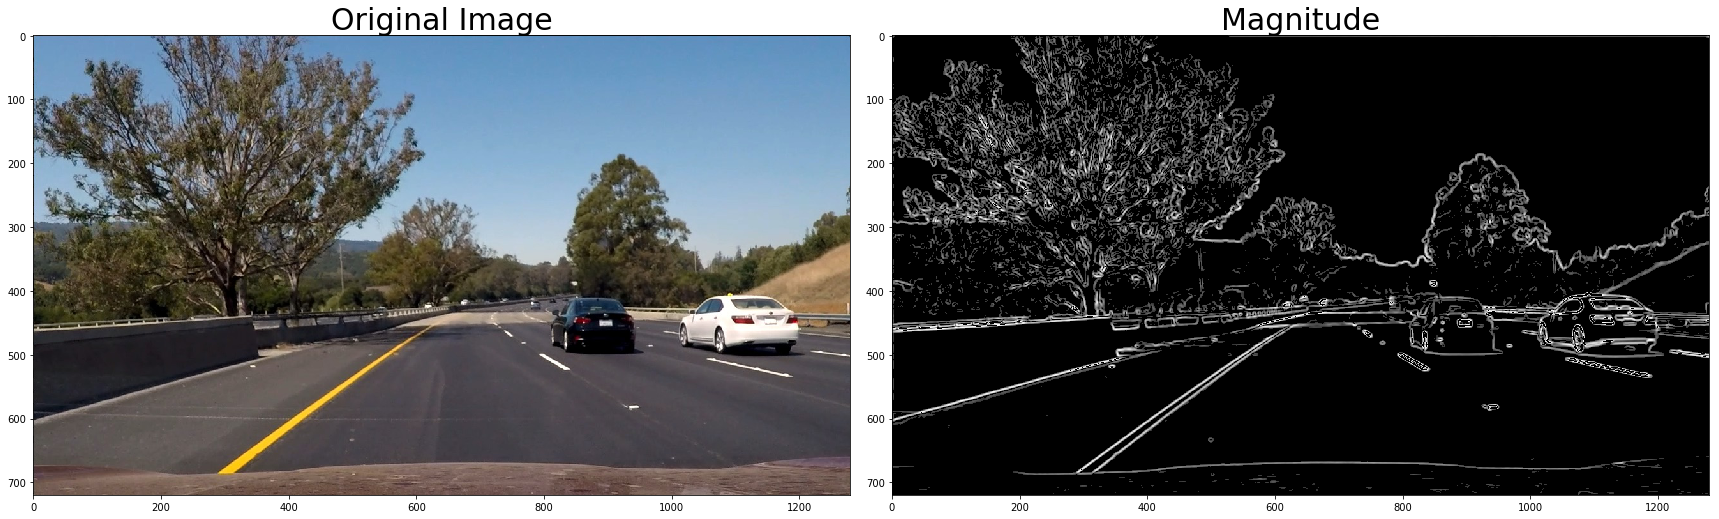

In [8]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Take both Sobel x and y gradients                                                                                                                                                                                                       
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude                                                                                                                                                                                                        
    gradmag = np.sqrt(sobelx**2 + sobely**2)                                                                                                                                                                                                                
    scaled_mag = np.uint8(255*gradmag/np.max(gradmag))
    # Create a binary image of ones where threshold is met, zeros otherwise                                                                                                                                                                   
    binary_output = scaled_mag.copy()
    binary_output[scaled_mag <= thresh[0]] = 0
    binary_output[scaled_mag > thresh[1]] = 0
    return binary_output

test6_gray = cv2.cvtColor(test6_img, cv2.COLOR_RGB2GRAY)
test6_gradient_mag = mag_thresh(test6_gray, sobel_kernel=9, thresh=(30, 150))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test6_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test6_gradient_mag, cmap='gray')
ax2.set_title('Magnitude', fontsize=30)
ret_img = test6_gradient_mag/np.max(test6_gradient_mag) * 255
cv2.imwrite('output_images/test6_gradient_magnitude.jpg', ret_img)

In [9]:
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = absgraddir.copy()
    binary_output[absgraddir <= thresh[0]] = 0
    binary_output[absgraddir > thresh[1]] = 0
    return binary_output

True

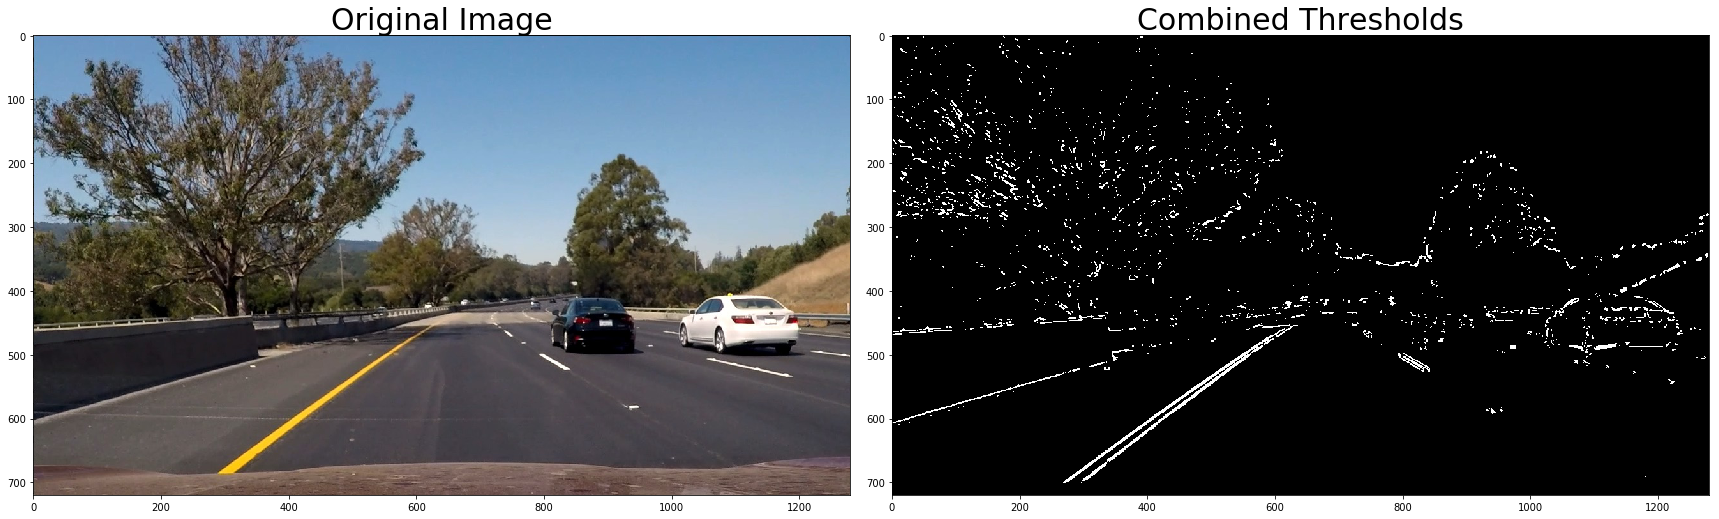

In [10]:
def combine_grad_thresholds(img, thresh=(110, 255)):
    img = np.copy(img)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    combined_rs = combine_rs(get_R(img), get_S(img))
    gradient_mag = mag_thresh(gray, sobel_kernel=9, thresh=(30, 150))
    gradient_dir = dir_thresh(gray, sobel_kernel=9, thresh=(0.8, 1.2))
      
    combined_gradients =  2 * get_binary(threshold_image(combined_rs, thresh=thresh)) * 255
    combined_gradients += (gradient_dir / np.max(gradient_dir) * 255)
    combined_gradients += 2 * (gradient_mag/ np.max(gradient_mag) * 255) 
    combined_gradients = combined_gradients / np.max(combined_gradients) * 255
    gauss_blur = cv2.GaussianBlur(combined_gradients, (3, 3), 0)
    return get_binary(threshold_image(gauss_blur, thresh=thresh))

test6_combined = combine_grad_thresholds(test6_img)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test6_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test6_combined, cmap='gray')
ax2.set_title('Combined Thresholds', fontsize=30)
ret_img = test6_combined * 255
cv2.imwrite('output_images/test6_combined_threshold.jpg', ret_img)

True

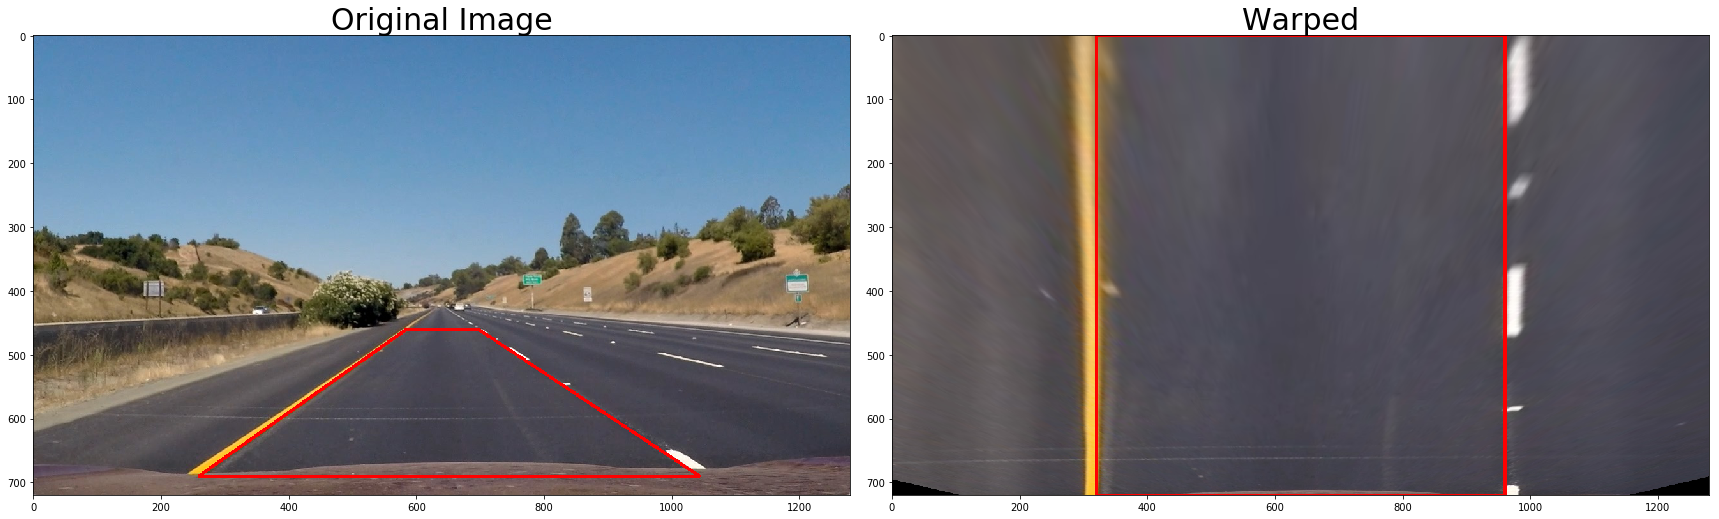

In [30]:
src = np.array([[585, 460], [697, 460], [1044, 690], [259, 690]], np.float32)
dst = np.array([[320, 0], [960, 0], [960, 720], [320, 720]], np.float32)
M = cv2.getPerspectiveTransform(src, dst)

def get_warped(image):
    return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

s1_img = mpimg.imread('test_images/straight_lines1.jpg')
s1_undist = cv2.undistort(s1_img, mtx, dist, None, mtx)
s1_warped = get_warped(s1_undist)
# draw polylines
cv2.polylines(s1_img, np.array([src], np.int32), True, (255,0,0), 4)
cv2.polylines(s1_warped, np.array([dst], np.int32), True, (255,0,0), 4)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(s1_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(s1_warped, cmap='gray')
ax2.set_title('Warped', fontsize=30)
cv2.imwrite('output_images/straight_lines1_warped.jpg', s1_warped)

In [12]:
Minv = cv2.getPerspectiveTransform(dst.astype(np.float32), src.astype(np.float32))

In [13]:
def search_lanes(binary_warped):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return (left_fit, right_fit)   

In [14]:
# detect lanes without searching again
def detect_lanes(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return (ploty, left_fitx, right_fitx)

In [19]:
def calculate_curvature(ploty, left_fit, right_fit):
    quadratic_coeff = 3e-4
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                             for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

# Find and print curvature
curvature_img = mpimg.imread('test_images/test1.jpg')
curvature_undist = cv2.undistort(curvature_img, mtx, dist, None, mtx)
curvature_threshold = combine_grad_thresholds(curvature_img)
curvature_warped = get_warped(curvature_threshold)
cr_left_fit, cr_right_fit = search_lanes(curvature_warped)
cr_ploty, cr_left_fitx, cr_right_fitx = detect_lanes(curvature_warped, cr_left_fit, cr_right_fit)
curad_left_curverad, curad_right_curverad = calculate_curvature(cr_ploty, cr_left_fit, cr_right_fit )
print("Detected curvature:")
print(curad_left_curverad, 'm', curad_right_curverad, 'm')


Detected curvature:
582.65464791 m 557.123503741 m


In [25]:
def map_lanes_image(warped, image, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

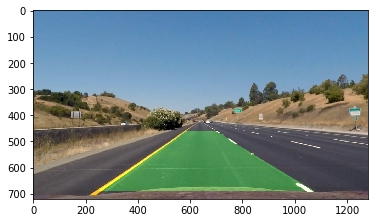

In [26]:
# Test on a single image
def single_image_test():
    sl1_img = mpimg.imread('test_images/straight_lines1.jpg')
    sl1_undist = cv2.undistort(sl1_img, mtx, dist, None, mtx)
    sl1_grad = combine_grad_thresholds(sl1_undist)
    sl1_warped = get_warped(sl1_grad)
    left_fit, right_fit = search_lanes(sl1_warped)
    ploty, left_fitx, right_fitx = detect_lanes(sl1_warped, left_fit, right_fit)
    calculate_curvature(ploty, left_fit, right_fit )
    Minv = cv2.getPerspectiveTransform(dst.astype(np.float32), src.astype(np.float32))
    result_image = map_lanes_image(sl1_warped, sl1_img, left_fitx, right_fitx, ploty, Minv)
    plt.imshow(result_image, cmap='gray')
single_image_test()

In [27]:
def process_image(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_threshold = combine_grad_thresholds(undist)
    warped = get_warped(img_threshold)
    left_fit, right_fit = search_lanes(warped)
    ploty, left_fitx, right_fitx = detect_lanes(warped, left_fit, right_fit)
    calculate_curvature(ploty, left_fit, right_fit )
    Minv = cv2.getPerspectiveTransform(dst, src)
    result_img = map_lanes_image(warped, img, left_fitx, right_fitx, ploty, Minv)
    return result_img

In [28]:
# Test on images
import os

for base, _, files in os.walk("test_images/"):
    for image_file in files:
        print("Processing %s" % image_file)
        image = mpimg.imread(os.path.join(base, image_file))
        out = os.path.join('output_images','%s' % image_file)
        result = process_image(image)
        plt.imsave(out, result)
        plt.close()

Processing test1.jpg
Processing test2.jpg
Processing test6.jpg
Processing test3.jpg
Processing test5.jpg
Processing test4.jpg
Processing straight_lines1.jpg
Processing straight_lines2.jpg


In [31]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lanes_output = 'lanes_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
result_clip = clip1.fl_image(process_image)
result_clip.write_videofile(lanes_output, audio=False)

[MoviePy] >>>> Building video lanes_video.mp4
[MoviePy] Writing video lanes_video.mp4


100%|█████████▉| 1260/1261 [14:50<00:00,  1.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: lanes_video.mp4 



In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lanes_output))